In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from neuraldistributions.models import transforms
from neuraldistributions.datasets import static

from multiprocessing import Pool

import os
device = "cuda"

dataport not available, will only be able to load data locally


In [2]:
import numpy as np
import torch

from neuraldistributions.datasets import mouse_static_loaders, extract_data_key
from neuraldistributions.models import poisson, zig, flowfa, ziffa
from neuraldistributions.trainers import base_trainer
from neuraldistributions.utility import get_loglikelihood

In [3]:
# setup data loading
random_seed=42
dataset_dir = "../project/data"
datasets = [
    "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6_dsampled.zip",
]
scan_id = [2, 1]
dataset_paths = [f"{dataset_dir}/{dataset}" for dataset in datasets]
areas = [["V1", "LM"]]
neurons_ns = [1000, 907]

In [4]:
dataset_index = 0
dataset_path = dataset_paths[dataset_index]
data_key = extract_data_key(dataset_path)
area = areas[dataset_index]
neurons_n = neurons_ns[dataset_index]

dataset_config = {
    "paths": [dataset_path],
    "seed": random_seed,
    "batch_size": 64,
    "area": area,
    "neurons_n": neurons_n,
    "normalize_images": True,
    "normalize_neurons": True,
    "return_more": True,
    "device": device,
    "shuffle_train": True,
}

dataloaders = mouse_static_loaders(**dataset_config)

100%|██████████| 5994/5994 [00:00<00:00, 293182.10it/s]


In [5]:
grid_mean_pred_config = {
    "type": "cortex",
    "input_dimensions": 2,
    "hidden_layers": 4,
    "hidden_features": 20,
    "nonlinearity": "ReLU",
    "final_tanh": True,
}

image_model_config = {
    "pad_input": False,
    "stack": -1,
    "layers": 4,
    "input_kern": 15,
    "gamma_input": 1,
    "gamma_readout": 2.439,
    "hidden_dilation": 1,
    "hidden_kern": 13,
    "hidden_channels": 64,
    "n_se_blocks": 0,
    "depth_separable": True,
    "share_features": False,
    "share_grid": False,
    "init_sigma": 0.4,
    "init_mu_range": 0.55,
    "gauss_type": "full",
    "grid_mean_predictor": grid_mean_pred_config,
}

In [6]:
model_name = "ziffa"
d_latent = 3
sample_transform = "learned2"
per_neuron_transform = True
unit_variance_constraint = False

model_config = {
    "image_model_fn": "neuraldistributions.models.controls.zif_fullgaussian2d",
    "image_model_config": image_model_config,
    "d_latent": d_latent,
    "sample_transform": sample_transform,
    "per_neuron_samples_transform": per_neuron_transform,
    "zero_threshold": 1.1e-7,
    "init_psi_diag_coef": 0.1,
    "init_C_coef": 0.1,
    "unit_variance_constraint": unit_variance_constraint,
}

model = ziffa(dataloaders, random_seed, **model_config)

In [7]:
# get name of dataloader
index_name_of_dataloader = next(iter(dataloaders["train"]))

# get indices of repeated samples
indexes = np.arange(len(dataloaders["image_ids"][index_name_of_dataloader]["test"]))
u, inv = (np.unique(dataloaders["image_ids"][index_name_of_dataloader]["test"], return_inverse=True))

# get the indices of the first ten repeated samples
img_indexes = indexes[inv == inv[0]]
print(img_indexes)

[0 1 2 3 4 5 6 7 8 9]


In [8]:
# sanity check to see if the wanted samples transform is actually loaded
print(model.sample_transform)

Flow(
  (layers): ModuleList(
    (0): Affine(
      init_t=Parameter containing:
      tensor([[-1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07,
               -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07,
               -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07,
               -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07,
               -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07,
               -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07,
               -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07,
               -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07,
               -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07,
               -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07,
               -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07, -1.1000e-07,
               -1.1000e-07, -1.1000e-0

In [ ]:
trainer_config = {
    "epochs": 500,
    "device": "cuda",
    "lr": 0.005,
    "use_avg_loss": True
}
out = None
## The following line would train the model (upon availability of the dataset)
out = base_trainer(model, dataloaders, random_seed, **trainer_config)

Score improved (nan --> -4708.626953).


100%|██████████| 70/70 [00:32<00:00,  2.13it/s]


Epoch 1/500 | train loss: -5927.832520 | val loss: -8632.803711
Score improved (-4708.626953 --> -8632.803711).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 2/500 | train loss: -8570.768555 | val loss: -8834.949219
Score improved (-8632.803711 --> -8834.949219).


100%|██████████| 70/70 [00:32<00:00,  2.13it/s]


Epoch 3/500 | train loss: -9001.215820 | val loss: -8955.457031
Score improved (-8834.949219 --> -8955.457031).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 4/500 | train loss: -8876.429688 | val loss: -9051.771484
Score improved (-8955.457031 --> -9051.771484).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 5/500 | train loss: -8928.869141 | val loss: -9130.193359
Score improved (-9051.771484 --> -9130.193359).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 6/500 | train loss: -9381.235352 | val loss: -9192.729492
Score improved (-9130.193359 --> -9192.729492).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 7/500 | train loss: -9330.688477 | val loss: -9242.634766
Score improved (-9192.729492 --> -9242.634766).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 8/500 | train loss: -9245.885742 | val loss: -9281.818359
Score improved (-9242.634766 --> -9281.818359).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 9/500 | train loss: -9503.810547 | val loss: -9312.860352
Score improved (-9281.818359 --> -9312.860352).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 10/500 | train loss: -9226.325195 | val loss: -9336.132812
Score improved (-9312.860352 --> -9336.132812).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 11/500 | train loss: -9340.250000 | val loss: -9353.611328
Score improved (-9336.132812 --> -9353.611328).


100%|██████████| 70/70 [00:32<00:00,  2.15it/s]


Epoch 12/500 | train loss: -9652.373047 | val loss: -9366.758789
Score improved (-9353.611328 --> -9366.758789).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 13/500 | train loss: -9455.597656 | val loss: -9376.324219
Score improved (-9366.758789 --> -9376.324219).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 14/500 | train loss: -9406.090820 | val loss: -9383.438477
Score improved (-9376.324219 --> -9383.438477).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 15/500 | train loss: -9118.953125 | val loss: -9389.193359
Score improved (-9383.438477 --> -9389.193359).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 16/500 | train loss: -9587.215820 | val loss: -9393.502930
Score improved (-9389.193359 --> -9393.502930).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 17/500 | train loss: -9349.866211 | val loss: -9396.425781
Score improved (-9393.502930 --> -9396.425781).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 18/500 | train loss: -9393.055664 | val loss: -9398.798828
Score improved (-9396.425781 --> -9398.798828).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 19/500 | train loss: -9508.260742 | val loss: -9400.674805
Score improved (-9398.798828 --> -9400.674805).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 20/500 | train loss: -9445.438477 | val loss: -9402.699219
Score improved (-9400.674805 --> -9402.699219).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 21/500 | train loss: -9523.645508 | val loss: -9403.767578
Score improved (-9402.699219 --> -9403.767578).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 22/500 | train loss: -9527.278320 | val loss: -9404.158203
Score improved (-9403.767578 --> -9404.158203).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 23/500 | train loss: -9707.796875 | val loss: -9405.074219
Score improved (-9404.158203 --> -9405.074219).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 24/500 | train loss: -9579.422852 | val loss: -9405.401367
Score improved (-9405.074219 --> -9405.401367).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 25/500 | train loss: -9272.067383 | val loss: -9405.808594
Score improved (-9405.401367 --> -9405.808594).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 26/500 | train loss: -9553.388672 | val loss: -9406.112305
Score improved (-9405.808594 --> -9406.112305).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 27/500 | train loss: -9469.938477 | val loss: -9405.911133
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 28/500 | train loss: -9469.755859 | val loss: -9406.548828
Score improved (-9406.112305 --> -9406.548828).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 29/500 | train loss: -9263.426758 | val loss: -9406.556641
Score improved (-9406.548828 --> -9406.556641).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 30/500 | train loss: -9380.632812 | val loss: -9407.507812
Score improved (-9406.556641 --> -9407.507812).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 31/500 | train loss: -9462.085938 | val loss: -9407.073242
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 32/500 | train loss: -9443.804688 | val loss: -9407.242188
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 33/500 | train loss: -9541.699219 | val loss: -9407.248047
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 34/500 | train loss: -9538.002930 | val loss: -9407.216797
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:32<00:00,  2.15it/s]


Epoch 35/500 | train loss: -9411.652344 | val loss: -9407.794922
Score improved (-9407.507812 --> -9407.794922).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 36/500 | train loss: -9370.250977 | val loss: -9407.892578
Score improved (-9407.794922 --> -9407.892578).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 37/500 | train loss: -9537.170898 | val loss: -9407.164062
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 38/500 | train loss: -9252.860352 | val loss: -9407.384766
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 39/500 | train loss: -9438.645508 | val loss: -9408.283203
Score improved (-9407.892578 --> -9408.283203).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 40/500 | train loss: -9431.433594 | val loss: -9407.453125
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 41/500 | train loss: -9196.481445 | val loss: -9407.931641
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 42/500 | train loss: -9601.876953 | val loss: -9407.869141
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 43/500 | train loss: -9424.875000 | val loss: -9408.461914
Score improved (-9408.283203 --> -9408.461914).


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 44/500 | train loss: -9245.747070 | val loss: -9407.730469
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Epoch 45/500 | train loss: -9466.569336 | val loss: -9408.955078
Score improved (-9408.461914 --> -9408.955078).


 81%|████████▏ | 57/70 [00:26<00:06,  2.14it/s]

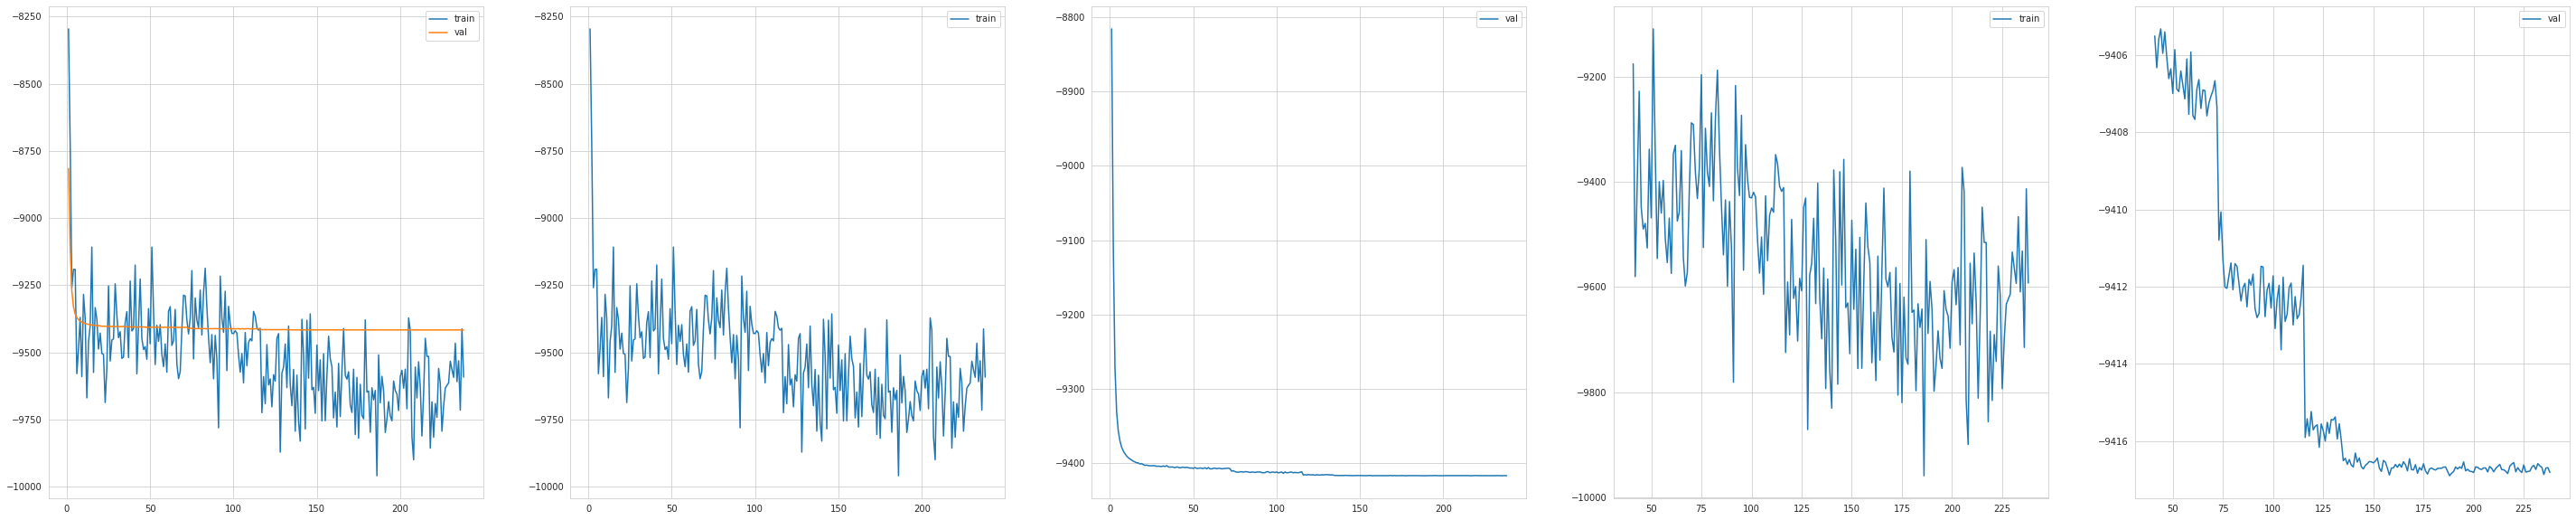

In [10]:
# plot training losses if we trained (additional plot after 40 epochs so we can see the later values better)
if out is not None:
    fig, ax = plt.subplots(1,5,figsize=(50,10))
    ax[0].plot((np.arange(len(out[1][0]))+1), out[1][0], label="train")
    ax[0].plot((np.arange(len(out[1][0]))+1), out[1][1], label="val")
    ax[1].plot((np.arange(len(out[1][0]))+1), out[1][0], label="train")
    ax[2].plot((np.arange(len(out[1][0]))+1), out[1][1], label="val")
    ax[3].plot((np.arange(len(out[1][0]))+1)[40:], out[1][0][40:], label="train")
    ax[4].plot((np.arange(len(out[1][0]))+1)[40:], out[1][1][40:], label="val")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()
    ax[4].legend()
    plt.show()

In [11]:
print(model)

ZeroInflatedFlowFA(
  (encoding_model): ZIFEncoder(
    (core): SE2dCore(
      (_input_weights_regularizer): LaplaceL2norm(
        (laplace): Laplace()
      )
      (features): Sequential(
        (layer0): Sequential(
          (conv): Conv2d(1, 64, kernel_size=(15, 15), stride=(1, 1), bias=False)
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (nonlin): ELU(alpha=1.0, inplace=True)
        )
        (layer1): Sequential(
          (ds_conv): DepthSeparableConv2d(
            (in_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (spatial_conv): Conv2d(64, 64, kernel_size=(13, 13), stride=(1, 1), padding=(6, 6), groups=64, bias=False)
            (out_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (nonlin): ELU(alpha=1.0, inplace=True)
      

In [12]:
from utility_extended import *

In [13]:
print(f"Train loss: {calcLossForDataset(model, dataloaders['train'], 1000, True)}\nVal loss: {calcLossForDataset(model, dataloaders['validation'], 1000, True)}\nTest loss: {calcLossForDataset(model, dataloaders['test'], 1000, True)}")

Train loss: -13.910167381315159
Val loss: -14.05379823307592
Test loss: -14.033425701969797


In [14]:
torch.save(model, "./models/ZIFFA-Original")